# 0. Setting Up The Env

## 0.1 Packages

In [51]:
from pathlib import Path

In [52]:
import pandas as pd 
import numpy as np


from scipy.stats import chi2_contingency

In [53]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [55]:
from mpl_toolkits.mplot3d import Axes3D

## 0.2 Utilities

In [56]:
def get_dummies_drop_least(df, cols):
    df_new = df.copy()
    for col in cols:
        # Category with the fewest values
        least_common = df[col].value_counts().idxmin()
        
        # One-hot encode
        dummies = pd.get_dummies(df[col], prefix=col, dtype=int)
        
        # Drop the least frequent category
        # dummies = dummies.drop(f"{col}_{least_common}", axis=1)
        print(f"{col}_{least_common}")
        
        df_new = df_new.drop(columns=[col]).join(dummies)
    
    return df_new

## 0.3 Constants

In [57]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [58]:
raw_file_path = f"{project_root}/data/raw/bank-additional.csv"
processed_file_path = f"{project_root}/data/processed/preprocessed_bank_2.csv"
raw_file_path, processed_file_path

('d:\\01 Work\\06-Segmentations/data/raw/bank-additional.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/preprocessed_bank_2.csv')

# 1. The Data

In [59]:
data_df  = pd.read_csv(raw_file_path, sep=";")
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 4119 rows and 21 columns
Data Preview:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


# 2. Data Changes

In [60]:
new_data_df = data_df.copy(deep=True)

## 2.0 Drop Nulls

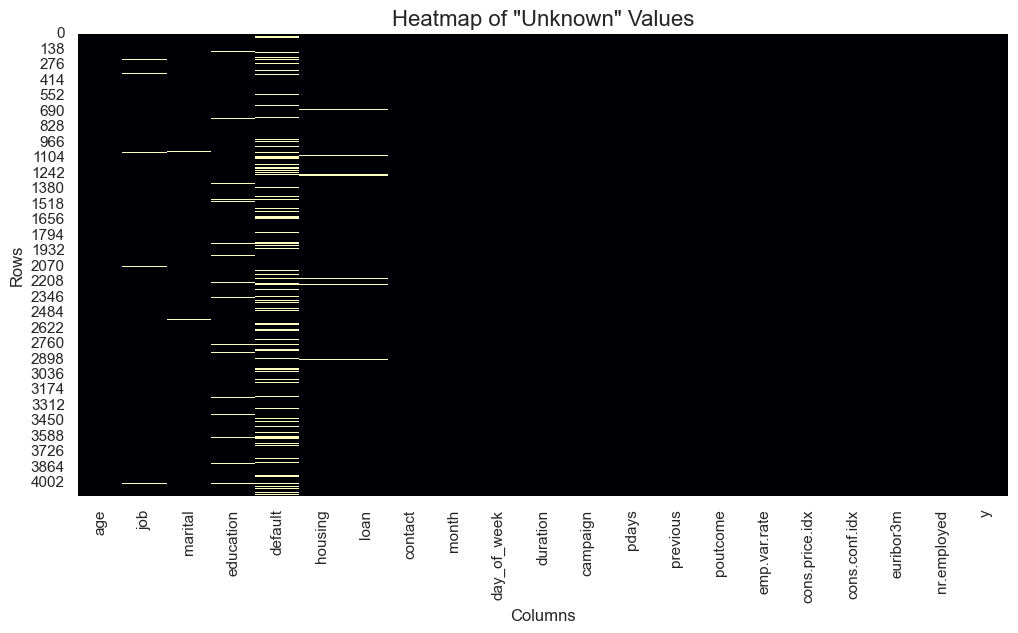

In [61]:
unknown_mask = new_data_df == "unknown"

plt.figure(figsize=(12,6))
sns.heatmap(unknown_mask, cbar=False, cmap="magma")  # or 'coolwarm', 'viridis'
plt.title('Heatmap of "Unknown" Values', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [62]:
print(new_data_df.shape)

new_data_df.drop("default", axis = 1, inplace=True)
print(new_data_df.shape)

new_data_df = new_data_df[~(new_data_df == "unknown").any(axis=1)]
print(new_data_df.shape)


(4119, 21)
(4119, 20)
(3811, 20)


In [63]:
new_data_df["day_of_week"].unique()

array(['fri', 'wed', 'mon', 'thu', 'tue'], dtype=object)

## 2.1 Categorical To Numerical

In [64]:
new_data_df['num_month'] = new_data_df['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})
new_data_df['sin_month'] = np.sin(new_data_df['num_month'] * (2 * np.pi / 12))
new_data_df['cos_month'] = np.cos(new_data_df['num_month'] * (2 * np.pi / 12))
new_data_df.drop(columns=["month", "num_month"], inplace=True)

In [65]:
new_data_df['num_day_of_week'] = new_data_df['day_of_week'].map({'mon':1, 'tue' :2, 'wed':3, 'thu':4, 'fri':5})
new_data_df['sin_day_of_week'] = np.sin(new_data_df['num_day_of_week'] * (2 * np.pi / 5))
new_data_df['cos_day_of_week'] = np.cos(new_data_df['num_day_of_week'] * (2 * np.pi / 5))
new_data_df.drop(columns=["day_of_week", "num_day_of_week"], inplace=True)

## 2.2 Categorical To Binary

In [66]:
temp = new_data_df.describe(include=['O']).T
# temp.sort_values(by = "unique")
temp

,count,unique,top,freq
job,3811,11,admin.,970
marital,3811,3,married,2330
education,3811,7,university.degree,1239
housing,3811,2,yes,2072
loan,3811,2,no,3177
contact,3811,2,cellular,2470
poutcome,3811,3,nonexistent,3268
y,3811,2,no,3398


In [67]:
binary_temp = temp[temp["unique"] == 2].index.tolist()
binary_temp.remove("contact")
binary_temp

['housing', 'loan', 'y']

In [68]:
for col in binary_temp:
    new_data_df[col] = new_data_df[col].map({"yes": 1, "no": 0})

new_data_df.head()

,age,job,marital,education,housing,loan,contact,duration,campaign,pdays,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,sin_month,cos_month,sin_day_of_week,cos_day_of_week
0,30,blue-collar,married,basic.9y,1,0,cellular,487,2,999,...,-1.8,92.893,-46.2,1.313,5099.1,0,5.000000e-01,-8.660254e-01,-2.449294e-16,1.000000
1,39,services,single,high.school,0,0,telephone,346,4,999,...,1.1,93.994,-36.4,4.855,5191.0,0,5.000000e-01,-8.660254e-01,-2.449294e-16,1.000000
2,25,services,married,high.school,1,0,telephone,227,1,999,...,1.4,94.465,-41.8,4.962,5228.1,0,1.224647e-16,-1.000000e+00,-5.877853e-01,-0.809017
4,47,admin.,married,university.degree,1,0,cellular,58,1,999,...,-0.1,93.200,-42.0,4.191,5195.8,0,-5.000000e-01,8.660254e-01,9.510565e-01,0.309017
5,32,services,single,university.degree,0,0,cellular,128,3,999,...,-1.1,94.199,-37.5,0.884,4963.6,0,-1.000000e+00,-1.836970e-16,-9.510565e-01,0.309017


## 2.3 Rest Categorical

In [69]:
temp = new_data_df.describe(include=['O']).T
temp = temp[temp["unique"] > 2].index.tolist()
temp.append('contact')
temp

['job', 'marital', 'education', 'poutcome', 'contact']

In [70]:
df_encoded = get_dummies_drop_least(new_data_df, temp)
df_encoded.head() 

job_student
marital_divorced
education_illiterate
poutcome_success
contact_telephone


,age,housing,loan,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,poutcome_failure,poutcome_nonexistent,poutcome_success,contact_cellular,contact_telephone
0,30,1,0,487,2,999,0,-1.8,92.893,-46.2,...,1,0,0,0,0,0,1,0,1,0
1,39,0,0,346,4,999,0,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,1
2,25,1,0,227,1,999,0,1.4,94.465,-41.8,...,0,1,0,0,0,0,1,0,0,1
4,47,1,0,58,1,999,0,-0.1,93.200,-42.0,...,0,0,0,0,1,0,1,0,1,0
5,32,0,0,128,3,999,2,-1.1,94.199,-37.5,...,0,0,0,0,1,1,0,0,1,0


* Lets keep all the columns for now, and select/drop columns considering factors other than null values also 

# 3. Plot

In [71]:
X = df_encoded.drop("y", axis = 1)
y = df_encoded.loc[:, "y"]

In [72]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

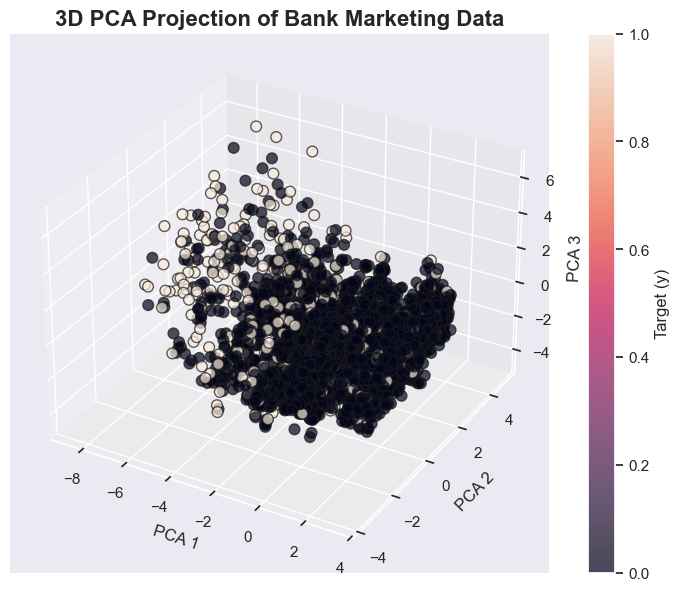

In [73]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

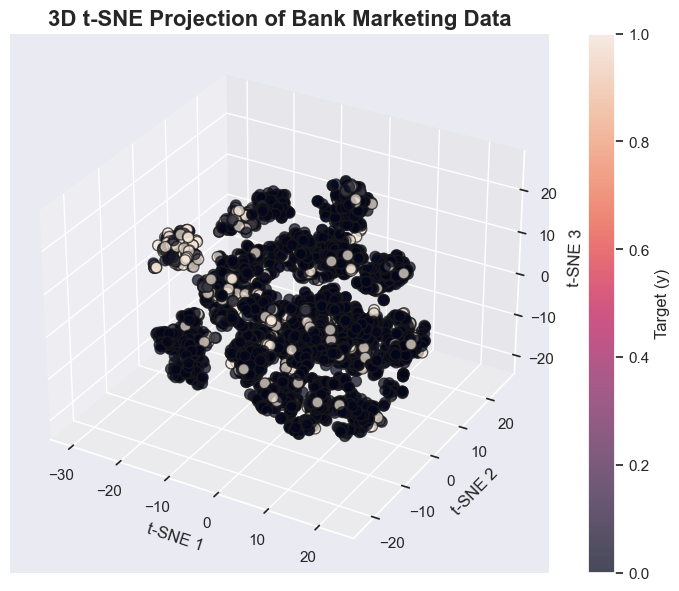

In [74]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_tsne_3d[:,0], X_tsne_3d[:,1], X_tsne_3d[:,2],
    c=y, alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.set_title("3D t-SNE Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()


# 4. Save

In [75]:
df_encoded.to_csv(processed_file_path, index=False)

# END